# Реализация и исследование модели Хольта-Уинтерса

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

In [ ]:
data = pd.read_csv('AirPassengers.csv')

In [ ]:
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
time_series = data['#Passengers'].values

In [ ]:
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Индекс (Month): Даты, начиная с января 1949 года до декабря 1960 года. Это означает, что у нас есть временной ряд с ежемесячной частотой в течение 12 лет. <br>

Столбец #Passengers: Этот столбец содержит количество пассажиров (в тысячах), перевезенных авиакомпанией в каждом месяце. Значение — это целое число, представляющее количество пассажиров в соответствующем месяце.


In [ ]:
data.describe()

NameError: name 'data' is not defined

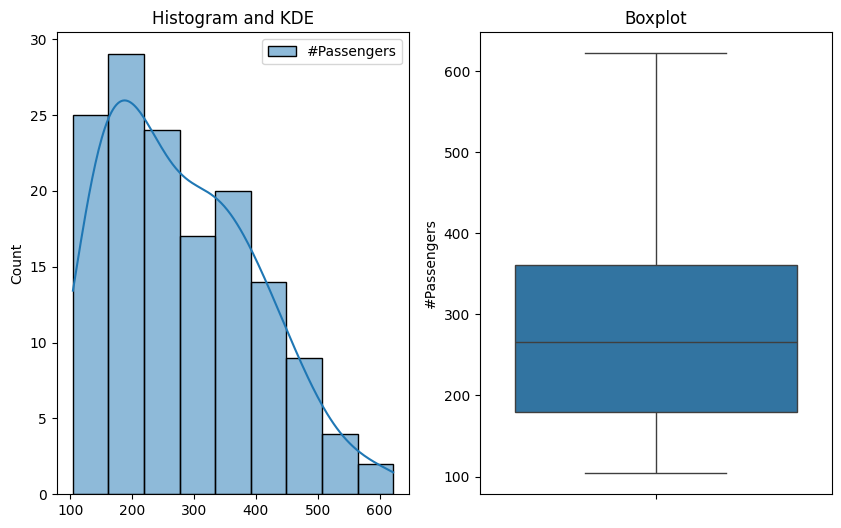

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(data, kde=True)
plt.title(f"Histogram and KDE")

plt.subplot(1, 2, 2)
sns.boxplot(y=data['#Passengers'])
plt.title(f"Boxplot")

plt.show()

Основные выводы:

В данных отсутствуют выбросы.

Гистограмма и KDE показывают, что распределение количества пассажиров асимметрично вправо. Это говорит о наличии периодов с высоким пассажиропотоком, что можно объяснить устойчивым ростом популярности авиаперелетов с течением времени.

Boxplot показывает значительный разброс значений: от 104 до 622 пассажиров.

Медиана меньше среднего значения, что указывает на положительную скошенность. Это также подтверждается KDE-графиком и распределением на гистограмме.

In [ ]:
# Мода
mode = data['#Passengers'].mode()[0]
mode

229

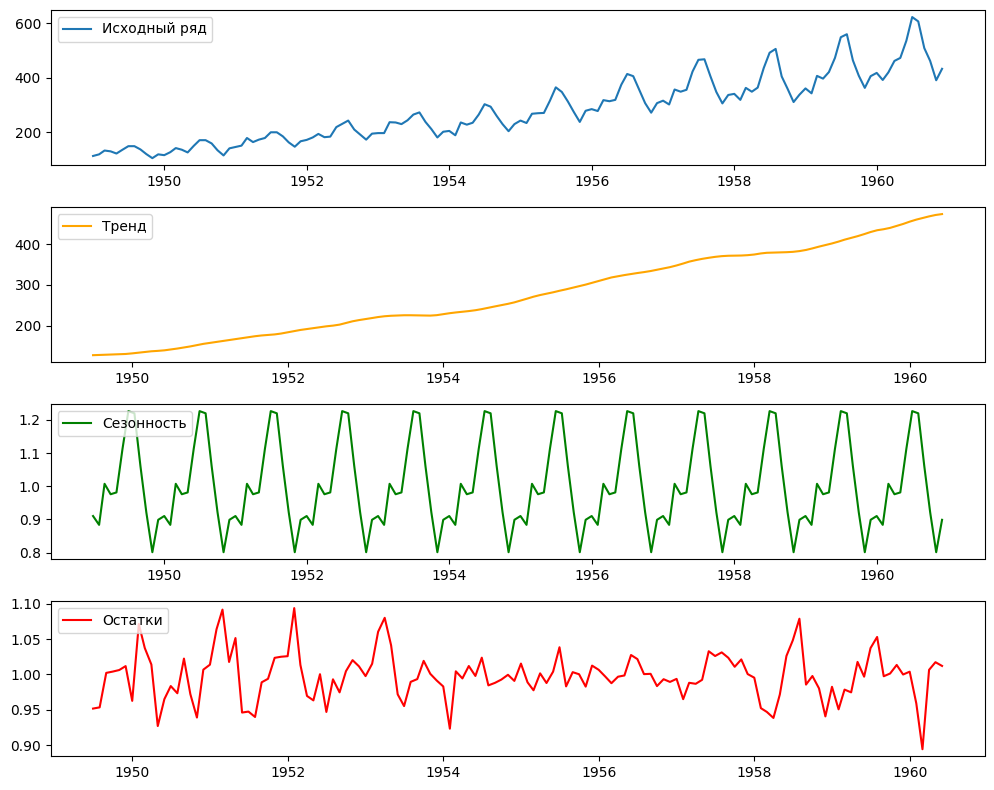

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Разложение временного ряда на компоненты
result = seasonal_decompose(data['#Passengers'], model='multiplicative', period=12)

# Построение графиков
plt.figure(figsize=(10, 8))

# Исходный ряд
plt.subplot(4, 1, 1)
plt.plot(data['#Passengers'], label='Исходный ряд')
plt.legend(loc='upper left')

# Тренд
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Тренд', color='orange')
plt.legend(loc='upper left')

# Сезонность
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')

# Остатки
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Остатки', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


На графике видно, что тренд имеет устойчивый рост на протяжении всего периода. Это говорит о постоянном увеличении популярности авиаперелетов и развитии индустрии авиаперевозок в указанный период.

<br>
Сезонность имеет характерный паттерн, повторяющийся каждый год, и в ней явно видны пики и спады.
Пики приходятся, вероятно, на летние месяцы, когда количество пассажиров возрастает из-за сезона отпусков.
Спады наблюдаются в зимние месяцы, когда пассажиропоток падает.
<br>
<br>
Остатки находятся в пределах от 0.90 до 1.10, что указывает на умеренные колебания, не влияющие значительно на общий тренд и сезонные паттерны.


# Модель без тюнинга

In [ ]:
# Пользовательская модель Хольта-Уинтерса
class HoltWintersRegression:
    def __init__(self, season_length, alpha1, alpha2, alpha3):
        self.season_length = int(round(season_length))
        self.alpha1 = alpha1  # Сглаживание уровня
        self.alpha2 = alpha2  # Сглаживание тренда
        self.alpha3 = alpha3  # Сглаживание сезонности

    def initialize_components(self, y):
        # Инициализация параметров уровня (b) и тренда (a) с помощью линейной регрессии на всем временном ряде
        time_index = np.arange(len(y)).reshape(-1, 1)

        # Построение линейной регрессии для оценки начального уровня и тренда
        lr = LinearRegression()
        lr.fit(time_index, y)

        # Установка начального уровня и тренда на основе коэффициентов регрессии
        self.b = lr.intercept_  # Начальный уровень
        self.a = lr.coef_[0]    # Начальный тренд

        # Инициализация сезонной компоненты F(t) для t = -p, ..., -1
        k = len(y) // self.season_length
        self.F = []
        for p in range(self.season_length):  # Итерация по всей длине сезона
            seasonal_sum = 0
            count = 0
            for i in range(1, k + 1):
                z_pi = i * self.season_length - p - 1  # Индекс для z(p, i), с учетом индексации в Python
                if 0 <= z_pi < len(y):
                    x_observed = y[z_pi]
                    x_predicted = self.b + self.a * z_pi
                    seasonal_sum += x_observed / x_predicted
                    count += 1
            self.F.append(seasonal_sum / count if count > 0 else 1) #усредняется делением суммы (seasonal_sum) на количество использованных значений (count).

    def fit(self, y):
        n = len(y)
        self.initialize_components(y)
        level, trend = self.b, self.a
        seasonality = self.F[:]
        forecast = []

        for t in range(n):
            if t >= self.season_length: #Если текущий момент времени t больше или равен длине сезона, то мы уже имеем достаточно информации для обновления сезонных компонент, уровня и тренда.
                # Предсказание значения
                forecast_value = (level + trend) * seasonality[t % self.season_length] #t % self.season_length находит индекс текущего периода в сезоне
                forecast.append(forecast_value)

                # Рассчитать новые компоненты уровня, тренда и сезонности
                level_new = self.alpha1 * (y[t] / seasonality[t % self.season_length]) + \
                            (1 - self.alpha1) * (level + trend)
                trend_new = self.alpha2 * (level_new - level) + (1 - self.alpha2) * trend
                seasonality[t % self.season_length] = self.alpha3 * (y[t] / level_new) + \
                                                      (1 - self.alpha3) * seasonality[t % self.season_length]
                level, trend = level_new, trend_new
            else:
                forecast.append(y[t])  # Используем наблюдаемые значения для первого сезона

        self.last_level = level
        self.last_trend = trend
        self.last_seasonality = seasonality
        return forecast

    def predict(self, h):
        predictions = []
        level, trend = self.last_level, self.last_trend
        seasonality = self.last_seasonality[:]

        for i in range(h):
            predictions.append((level + trend * (i + 1)) * seasonality[(len(seasonality) + i) % self.season_length])
        return predictions

In [ ]:
# Параметры модели
season_length = 12
alpha1 = 0.5
alpha2 = 0.2
alpha3 = 0.8
forecast_horizon = 12

In [ ]:
# Запуск модели в обычном режиме
model = HoltWintersRegression(season_length, alpha1, alpha2, alpha3)
full_forecast = model.fit(time_series)
forecast = model.predict(h=forecast_horizon)
full_forecast.extend(forecast)

# Сбор параметров модели
model_parameters = {
    "Level (Intercept)": model.last_level,  # Уровень
    "Trend (Slope)": model.last_trend,      # Тренд (наклон)
    "Last Seasonality": model.last_seasonality[-1]  # Последняя сезонная компонента
}

# Вывод параметров модели
print("\nModel Parameters:")
for key, value in model_parameters.items():
    print(f"{key}: {value}")

# Вывод прогнозируемых значений
print("\nFull Forecast Values:")
for i, value in enumerate(forecast, 1):
    print(f"Forecast Month {i}: {value}")

# Вычисление среднеквадратичной ошибки для внутривыборочного прогноза
mse = mean_squared_error(time_series, full_forecast[:len(time_series)])
print(f"\nMean Squared Error (MSE) for in-sample forecast: {mse}")



Model Parameters:
Level (Intercept): 515.2001116567403
Trend (Slope): 8.571390145780432
Last Seasonality: 0.8379889648718853

Full Forecast Values:
Forecast Month 1: 452.0966322812468
Forecast Month 2: 436.88202623413065
Forecast Month 3: 510.0086106493134
Forecast Month 4: 552.6107031420939
Forecast Month 5: 582.4230913494423
Forecast Month 6: 679.2238725725528
Forecast Month 7: 789.5790916415818
Forecast Month 8: 776.0825782880466
Forecast Month 9: 637.1849676922737
Forecast Month 10: 555.9788519453843
Forecast Month 11: 469.68379442701684
Forecast Month 12: 517.924772538419

Mean Squared Error (MSE) for in-sample forecast: 373.76925943685274


<ipython-input-92-8e5706a5ddd3>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=data.index[0], periods=len(full_forecast), freq='M')


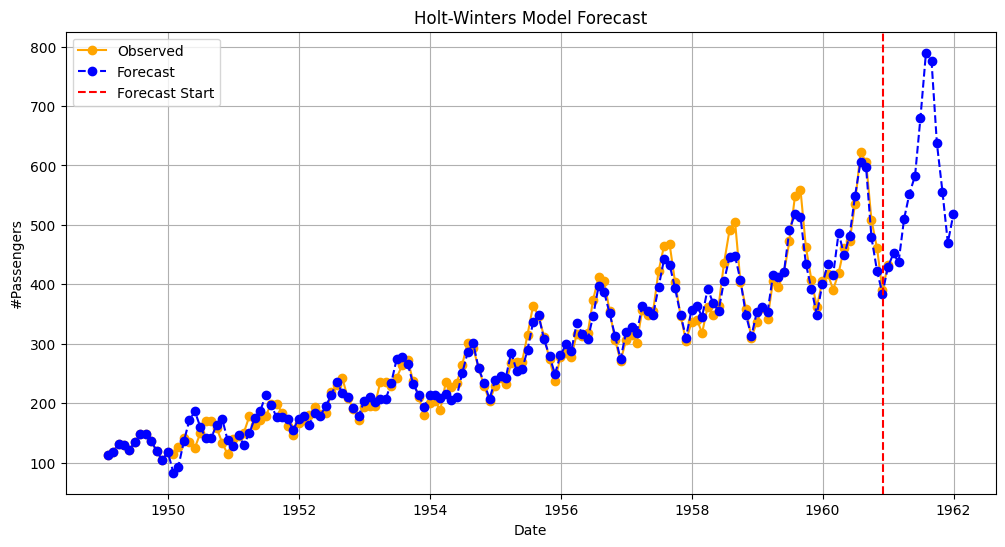

In [ ]:
# Построение графика наблюдаемых и прогнозных значений
dates = pd.date_range(start=data.index[0], periods=len(full_forecast), freq='M')

plt.figure(figsize=(12, 6))
plt.plot(dates[:len(time_series)], time_series, label="Observed", marker='o', linestyle='-', color='orange')
plt.plot(dates, full_forecast, label="Forecast", marker='o', linestyle='--', color='blue')
plt.axvline(x=data.index[-1], color='red', linestyle='--', label="Forecast Start")
plt.legend()
plt.title("Holt-Winters Model Forecast")
plt.xlabel("Date")
plt.ylabel("#Passengers")
plt.grid()
plt.show()

# Тюнинг модели

In [ ]:
# Функция для настройки гиперпараметров модели с использованием метода минимизации ошибки
def tune_holt_winters_minimize(time_series):
    mse_history = []
    def objective(params):
        season_length, alpha1, alpha2, alpha3 = params
        season_length = int(round(season_length))
        model = HoltWintersRegression(season_length, alpha1, alpha2, alpha3)
        predictions = model.fit(time_series)
        mse = mean_squared_error(time_series, predictions)
        mse_history.append(mse)
        return mse

    # Ограничения для гиперпараметров: длина сезона (6-24), alpha1, alpha2, alpha3 (0-1)
    bounds = [(3, 24), (0, 1), (0, 1), (0, 1)]
    result = minimize(objective, x0=[12, 0.5, 0.5, 0.5], bounds=bounds, method='L-BFGS-B')
    optimal_params = result.x
    optimal_params[0] = int(round(optimal_params[0]))  # Округлить длину сезона до ближайшего целого числа
    return optimal_params, result.fun

In [ ]:
# Настройка гиперпараметров модели с использованием метода минимизации
optimal_params, best_score = tune_holt_winters_minimize(time_series)
season_length = optimal_params[0]
alpha1 = optimal_params[1]
alpha2 = optimal_params[2]
alpha3 = optimal_params[3]

# Горизонт прогнозирования
forecast_horizon = 12

# Запуск модели с настроенными параметрами
model = HoltWintersRegression(season_length, alpha1, alpha2, alpha3)
full_forecast = model.fit(time_series)
forecast = model.predict(h=forecast_horizon)
full_forecast.extend(forecast)

# Сбор параметров модели
model_parameters = {
    "Level (Intercept)": model.last_level,
    "Trend (Slope)": model.last_trend,
    "Last Seasonality": model.last_seasonality[-1]
}

# Печать оптимальных гиперпараметров
print("\nOptimal Hyperparameters:")
print(f"Season Length: {season_length}")
print(f"Alpha1: {alpha1}")
print(f"Alpha2: {alpha2}")
print(f"Alpha3: {alpha3}")
print(f"Best Score (MSE): {best_score}")

# Печать параметров модели
print("\nModel Parameters:")
for key, value in model_parameters.items():
    print(f"{key}: {value}")

# Печать прогнозных значений
print("\nFull Forecast Values:")
for i, value in enumerate(forecast, 1):
    print(f"Forecast Month {i}: {value}")



Optimal Hyperparameters:
Season Length: 12.0
Alpha1: 0.24992244174351538
Alpha2: 0.0
Alpha3: 0.7972127276111437
Best Score (MSE): 169.046140172847

Model Parameters:
Level (Intercept): 474.0858957649949
Trend (Slope): 2.6571839080459774
Last Seasonality: 0.9117233864601132

Full Forecast Values:
Forecast Month 1: 446.73826505849837
Forecast Month 2: 419.45439576565695
Forecast Month 3: 465.71710403728883
Forecast Month 4: 493.3855723641531
Forecast Month 5: 505.5156504739667
Forecast Month 6: 573.5124540906396
Forecast Month 7: 662.8939540343855
Forecast Month 8: 654.2749845856966
Forecast Month 9: 545.9020483691619
Forecast Month 10: 488.0748697102772
Forecast Month 11: 416.6259975252957
Forecast Month 12: 461.30659889292934


<ipython-input-86-ffc16360a282>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=data.index[0], periods=len(full_forecast), freq='M')


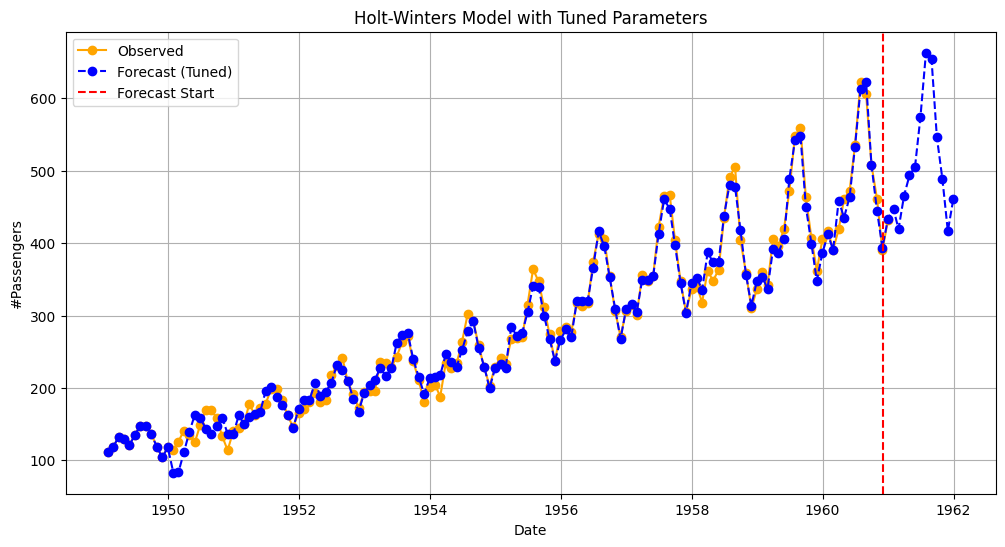

In [ ]:
# Построить график наблюдаемых и прогнозных значений
dates = pd.date_range(start=data.index[0], periods=len(full_forecast), freq='M')

plt.figure(figsize=(12, 6))
plt.plot(dates[:len(time_series)], time_series, label="Observed", marker='o', linestyle='-', color='orange')
plt.plot(dates, full_forecast, label="Forecast (Tuned)", marker='o', linestyle='--', color='blue')
plt.axvline(x=data.index[-1], color='red', linestyle='--', label="Forecast Start")
plt.legend()
plt.title("Holt-Winters Model with Tuned Parameters")
plt.xlabel("Date")
plt.ylabel("#Passengers")
plt.grid()
plt.show()

Значение MSE уменьшилось в два раза после оптимизации. Это означает, что оптимизированная модель лучше подстраивается под исторические данные и обеспечивает более точные прогнозы.